# Basic Usage


In the following, we guide you through how to use the adaptable experimentalist, specifically the adaptable_sample function. We provide some insights on internal workings as well.

The adaptable experimentalist takes a list of sampling methods and an arbitrary projection of them into a meta-sampler space (currently a 1D line), and adapts the weights of the sampling methods based on a meta score function and a temperature parameter.  
By default, the meta score function used is a surprisal score based on the Jensen-Shannon divergence of previous models. This meta score is then mapped into the meta-sampler space, and the samplers are weighted with a Gaussian around that point. The temperature parameter is used to control the width of the Gaussian.

In [1]:
from autora.experimentalist.adaptable import adaptable_sample
from autora.experimentalist.confirmation import confirmation_score_sample
from autora.experimentalist.falsification import falsification_score_sample
from autora.experimentalist.novelty import novelty_score_sample

import numpy as np
import matplotlib.pyplot as plt

Helper functions for giving some insight into the internal workings of the adaptable experimantalist:

In [2]:
import json
import os

# reading some internal optionally saved values
def read_internal_values(index=0):
    # read the inspection_plots
    # get all the files in inspection_plots/samplers_space/ with the dir path included
    samplers_spaces_files = os.listdir("inspection_plots/samplers_space/")
    surprisal_score_dists_files = os.listdir("inspection_plots/surprisal_score_dists/")
    # sort according to the date from newer to older
    samplers_spaces_files.sort(key=lambda x: os.path.getmtime("inspection_plots/samplers_space/" + x), reverse=True)
    surprisal_score_dists_files.sort(key=lambda x: os.path.getmtime("inspection_plots/surprisal_score_dists/" + x), reverse=True)

    with open("inspection_plots/samplers_space/" + samplers_spaces_files[index]) as f:
        samplers_space = json.load(f)

    with open("inspection_plots/surprisal_score_dists/" + surprisal_score_dists_files[index]) as f:
        surprisal_score_dists = json.load(f)
    
    return samplers_space, surprisal_score_dists

# plot the surprisal score distributions and the samplers space
def plot_internal_values(samplers_space, surprisal_score_dists):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].plot(samplers_space["x"], samplers_space["y"], label="gaussian distribution around the current progress")
    ax[0].axvline(x=samplers_space["mu"], color="r", linestyle="--", label="current_meta_score")
    # ax[0]lt.axvline(x=samplers_coords[samplers_space["index_closest_sampler"]], color="g", linestyle="--", label="closest sampler")
    ax[0].set_xticks(samplers_space["samplers_coords"], samplers_space["samplers_names"], rotation=45)
    ax[0].legend()
    ax[0].set_title(
        f"current tempreture: {np.round(samplers_space["temperature"], 6)}, current meta score: {np.round(samplers_space['current_meta_score'], 6)} \
            \nnormalized meta score projection: {np.round(samplers_space['current_projection'], 6)}\
            \nmu:{np.round(samplers_space['mu'], 6)}, std:{samplers_space['std']}"
    )
    ax[0].set_xlabel("samplers-space")
    ax[0].set_ylabel("density")

    ax[1].plot(surprisal_score_dists["shared_x"], surprisal_score_dists["normalized_current_distribution"], label="current")
    ax[1].plot(surprisal_score_dists["shared_x"], surprisal_score_dists["normalized_prior_disribution"], label="prior")
    # ax[1].set_suptitle("Normalized distributions")
    ax[1].set_title(f"KL divergence: {np.round(surprisal_score_dists['score_kld'], 6)} | JS divergence: {np.round(surprisal_score_dists['score_jsd'], 6)}")
    ax[1].set_xlabel("observations")
    ax[1].set_ylabel("normalized density")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

We demonstrate the usage of the adaptable_sample function on a simple example.

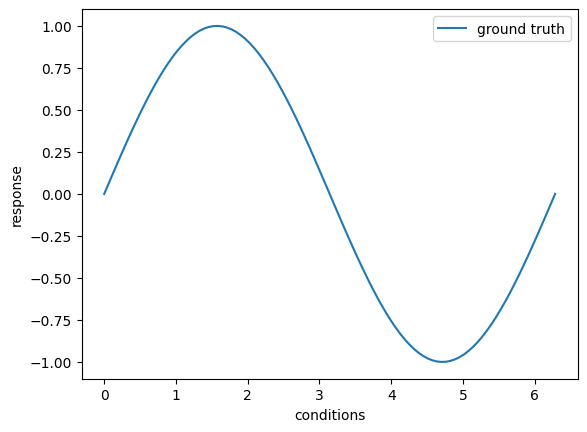

In [3]:
# define a ground truth model for 1d experimental conditions
ground_truth = lambda x: np.sin(x) 

conditions_pool = np.linspace(0, 2*np.pi, 100)

plt.plot(conditions_pool, ground_truth(conditions_pool), label='ground truth')
plt.xlabel('conditions')
plt.ylabel('response')
plt.legend()
plt.show()

Now we sample with the adaptable sampler with 3 sampling methods.
Here, since we don't provide any meta score function, the default surprisal score is used and when no prior is provided a uniform prior is assumed.
For illustration purposes, we will pass a prior identical to the current model, hence envoking one extreme case of the surprisal score, where the surprisal score is zero due to perfect match.

In [4]:
from sklearn.linear_model import LinearRegression

# setting up the adaptable experimentalist

reference_conditions = np.linspace(0.2*np.pi, 0.6*np.pi, 5)
reference_observations = ground_truth(reference_conditions)

model = LinearRegression()
model.fit(reference_conditions.reshape(-1, 1), reference_observations)
models = [model, model] # the models are used as references point to chnages in priors

# defining the sampling methods
samplers = [
    {
            "func": novelty_score_sample,
            "name": "novelty",
            "params": {"reference_conditions": reference_conditions},
        },
        {
            "func": falsification_score_sample,
            "name": "falsification",
            "params": {
                "reference_conditions": reference_conditions,
                "reference_observations": reference_observations,
                # "metadata": meta_data,
                "model": models[-1],
            },
        },
        {
            "func": confirmation_score_sample,
            "name": "confirmation",
            "params": {
                "reference_conditions": reference_conditions,
                "reference_observations": reference_observations,
                # "metadata": meta_data,
                "model": models[-1],
            },
        },
    ]

samplers_coords = [1, 2, 4]
temperature = 0.1
num_samples = 10

sampled_conditions = adaptable_sample(
    conditions=conditions_pool.reshape(-1, 1),
    reference_conditions=reference_conditions.reshape(-1, 1),
    models=models,
    samplers=samplers,
    num_samples=num_samples,
    samplers_coords=samplers_coords,
    temperature=temperature,
    plot_info=True,
    )

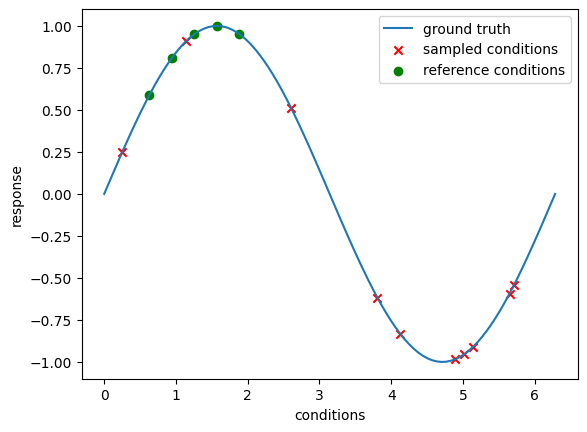

In [5]:
# plot the sampled conditions
plt.plot(conditions_pool, ground_truth(conditions_pool), label='ground truth')
plt.scatter(sampled_conditions, ground_truth(sampled_conditions), label='sampled conditions', color='red', marker='x')
# plot the reference conditions
plt.scatter(reference_conditions, reference_observations, label='reference conditions', color='green')
plt.xlabel('conditions')
plt.ylabel('response')
plt.legend()
plt.show()

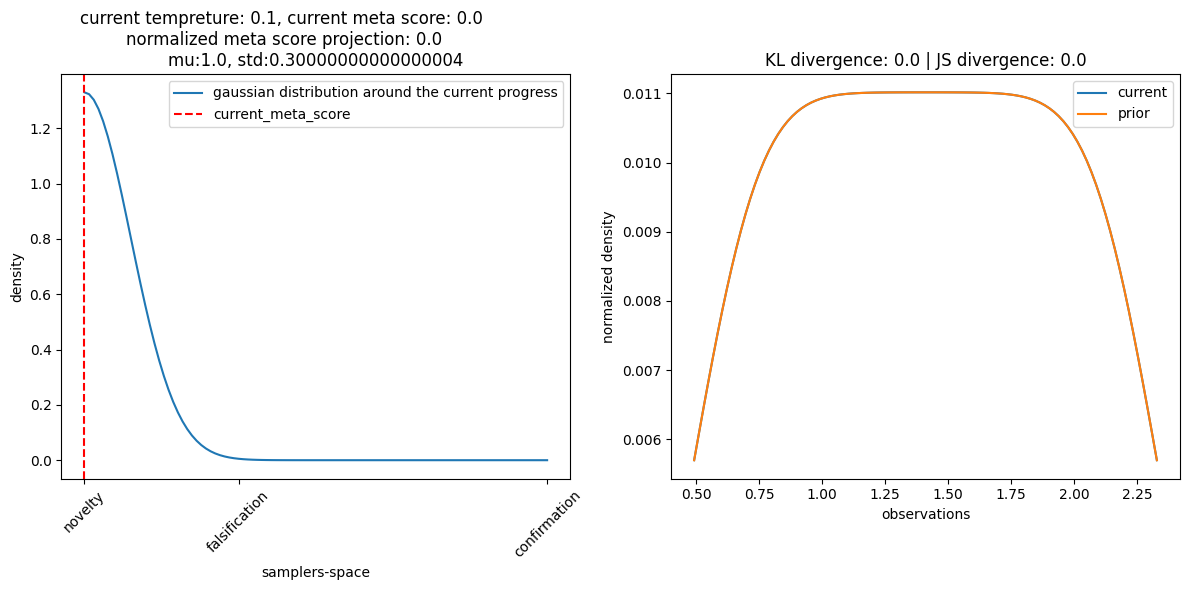

samplers weights:
('novelty', 0.9961) ('falsification', 0.0039) ('confirmation', 0.0)


In [6]:
samplers_space, surprisal_score_dists = read_internal_values()
plot_internal_values(samplers_space, surprisal_score_dists)
print("samplers weights:")
print(*zip(samplers_space["samplers_names"], np.round(samplers_space["samplers_weights"], 4)))


when the priors change, the experimantalist adapts based on its meta score function.
Here, in case of high surprisal score, the model will tend to use more conformist sampling methods

In [7]:
# we make a model that greatly diverges from the previous one
# add too much noise to the fit data
model = LinearRegression()
model.fit(reference_conditions.reshape(-1, 1), reference_observations + np.random.normal(0, 0.5, reference_observations.shape))
model.fit(reference_conditions.reshape(-1, 1), np.cos(reference_conditions))

models.append(model)

temperature = 0.1

sampled_conditions = adaptable_sample(
    conditions=conditions_pool.reshape(-1, 1),
    reference_conditions=reference_conditions.reshape(-1, 1),
    models=models,
    samplers=samplers,
    num_samples=num_samples,
    samplers_coords=samplers_coords,
    temperature=temperature,
    plot_info=True,
    )

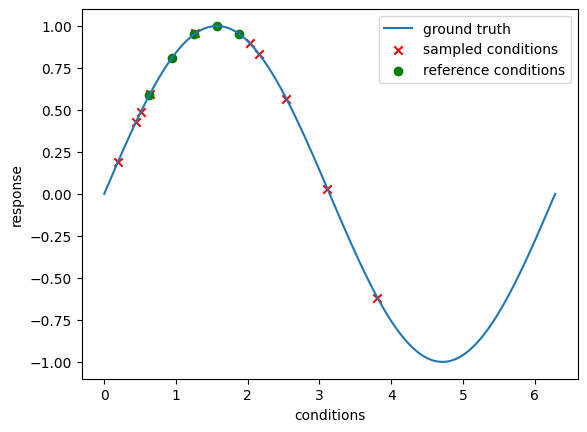

In [8]:
# plot the sampled conditions
plt.plot(conditions_pool, ground_truth(conditions_pool), label='ground truth')
plt.scatter(sampled_conditions, ground_truth(sampled_conditions), label='sampled conditions', color='red', marker='x')
# plot the reference conditions
plt.scatter(reference_conditions, reference_observations, label='reference conditions', color='green')
plt.xlabel('conditions')
plt.ylabel('response')
plt.legend()
plt.show()

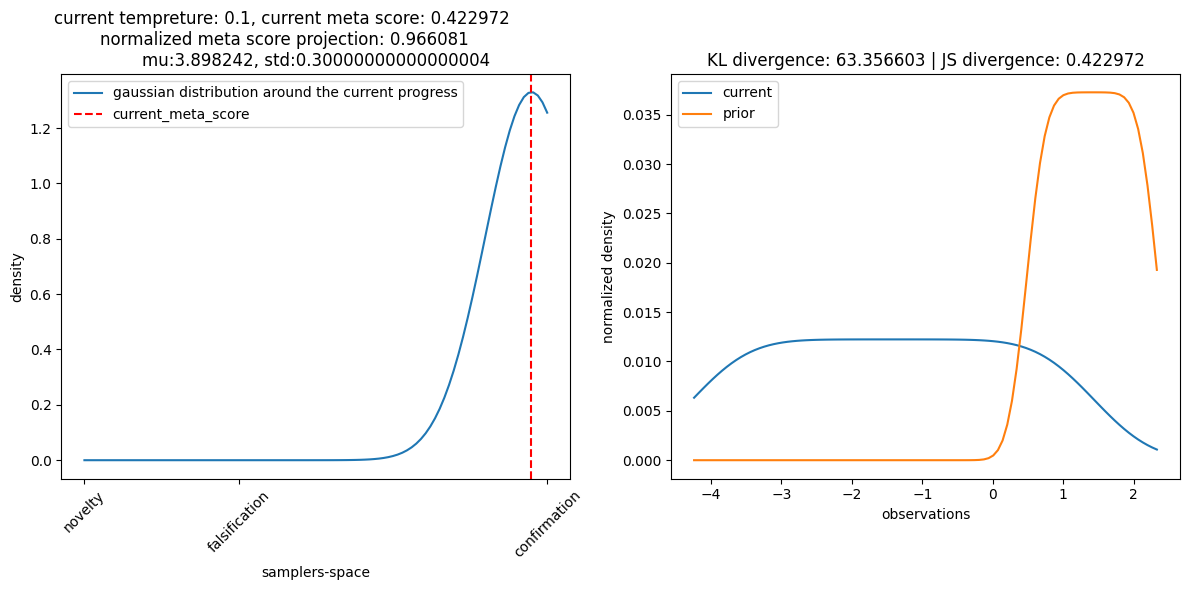

samplers weights:
('novelty', 0.0) ('falsification', 0.0) ('confirmation', 1.0)


In [9]:
samplers_space, surprisal_score_dists = read_internal_values()
plot_internal_values(samplers_space, surprisal_score_dists)
print("samplers weights:")
print(*zip(samplers_space["samplers_names"], np.round(samplers_space["samplers_weights"], 4)))


The effect of the tempreture is controling the width of the std of the gaussian, hence more exploratory weighting of the samplers.

In [10]:
temperature = 0.7
sampled_conditions = adaptable_sample(
    conditions=conditions_pool.reshape(-1, 1),
    reference_conditions=reference_conditions.reshape(-1, 1),
    models=models, 
    samplers=samplers,
    num_samples=num_samples,
    samplers_coords=samplers_coords,
    temperature=temperature,
    plot_info=True,
    )

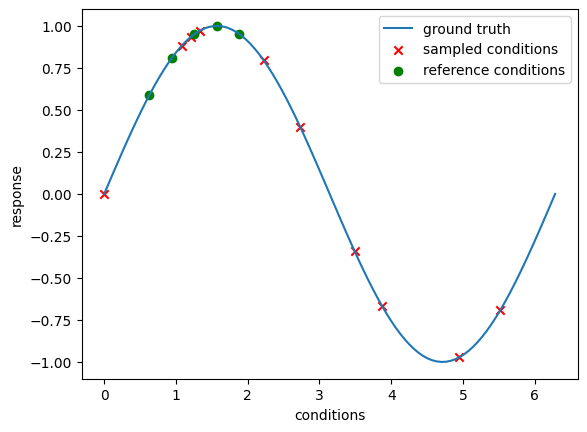

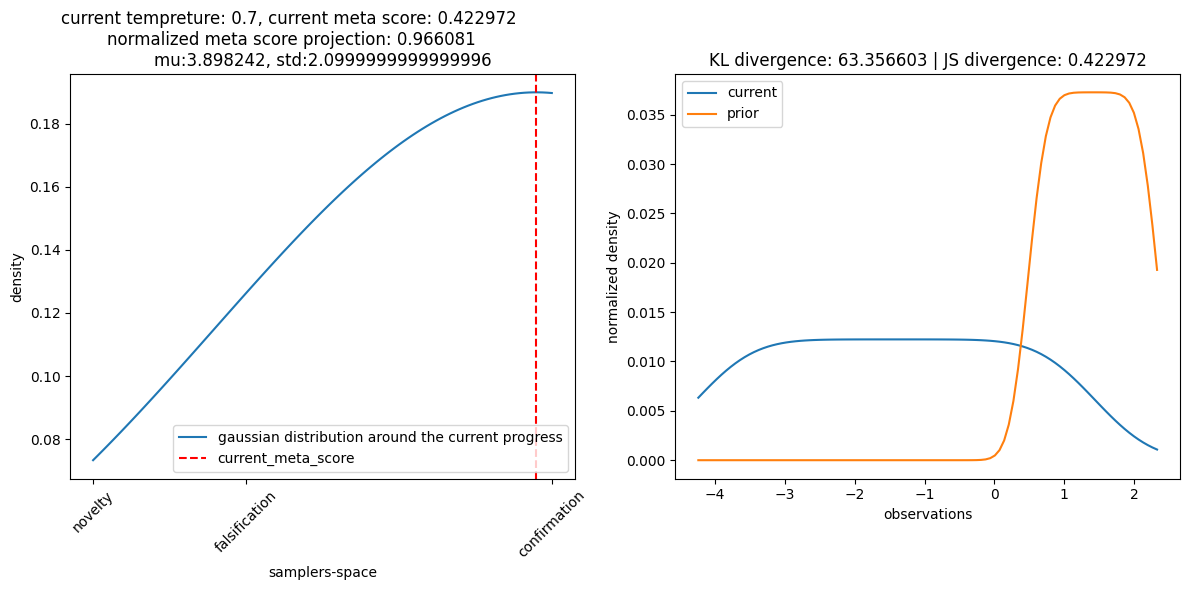

samplers weights:
('novelty', 0.1883) ('falsification', 0.3243) ('confirmation', 0.4874)


In [11]:
# plot the sampled conditions
plt.plot(conditions_pool, ground_truth(conditions_pool), label='ground truth')
plt.scatter(sampled_conditions, ground_truth(sampled_conditions), label='sampled conditions', color='red', marker='x')
# plot the reference conditions
plt.scatter(reference_conditions, reference_observations, label='reference conditions', color='green')
plt.xlabel('conditions')
plt.ylabel('response')
plt.legend()
plt.show()

samplers_space, surprisal_score_dists = read_internal_values()
plot_internal_values(samplers_space, surprisal_score_dists)
print("samplers weights:")
print(*zip(samplers_space["samplers_names"], np.round(samplers_space["samplers_weights"], 4)))
